# TDI Final Interview

Overview:

In this project, I will be building a ML model to describe a relationship between a scholar's publication record and his/her salary. I will be first using publicly available data on the salary of state employees who are affiliated with universities or research institutions, and scraping data from Google Scholar to extract each scholar's publication record. This project will first begin with the data extracted from Washington State, and will expand to other States in the United States that have made salary information publicly available. Below is a summary of steps to follow:

1) Scraping publication record from google scholar. Information to be extracted includes total number of citations, yearly citations, h-index, 5 year h-index, i10-index, 5 year i10-index, research interests, number of papers, impact factor of journals, etc...

2) Analyze, identify patterns and explore data. I will try to visualize some key patterns from the extracted dataset.

3) Pre-process data prior to ML. Ex. feature scaling, binning some features/labels into categories, converting categorical features into ordinals, outlier filtering, etc... 

4) Comparison of ML algorithms and selecting the appropriate algorithm

5) Fine tuning ML algorithm and validation of the algorithm

##  1) Scraping publication record from google scholar

Following inclusion criteria were used for the initial data scraping:

1) Names and salaries were found from WaStEmployeeHistSalary.csv (downloaded from http://fiscal.wa.gov/salaries)

2) From this database, 5 Affiliations were included: University of Washington, Washington State University, Central Washington University, Eastern Washington University, Western Washington University

3) From each affiliation, 3 Positions were included: PROFESSOR, ASSOCIATE PROFESSOR, and ASSISTANT PROFESSOR

In [3]:
def gscholarMining(aff, pos):
        
    import scholarly
    import pandas as pd
    import time
    from time import sleep
    from random import randint


    ### Import CSV file containing salaries of Washington State Employees, and remove white spaces in each column
    df = pd.read_csv('WaStEmployeeHistSalary.csv')
    df['Name'] = df['Name'].str.strip()
    df['Affiliation'] = df['Affiliation'].str.strip()
    df['Position'] = df['Position'].str.strip()

    ### Remove rows that are listed as 'Name Withheld'
    df = df[df.Name != 'Name Withheld']

    ### Filter out affiliations
    df = df[df.Affiliation == aff]

    ### Filter out positions
    df = df[df.Position == pos].reset_index()

    ### Create a new dataframe for our google scholar query
    fname = 'gscholar_' + pos + '_' + aff + '.csv'
    df_gscholar = pd.DataFrame(columns=['Name','Total Citations', 'h-index', '5 year h-index', 'i10-index', '5 year i10-index'])
    df_gscholar.to_csv(fname)

    ### Data mining from google scholar. Go through all the names in df, and extract publication record of each individual from google scholar
    start_time = time.time()
    aff = aff
    n = len(df)
    with open(fname, 'a') as f:
        for index in range(0, n):
            sleep(randint(1,10)) ### randomly sleep between 1 to 10 seconds for each iteration to prevent being blocked by Google
            print "Searching Number:", index+1, '/', n
            name = df.Name[index]
            position = df.Position[index]
            print name, "(", position, ")", "in",  aff
            search_query = scholarly.search_author(name + ',' + aff)
            author = next(search_query, None)
            if author is None:
                row = [name, 'NA', 'NA', 'NA', 'NA', 'NA']
                df_gscholar.loc[index] = row
                continue
            else:
                try:
                    author = author.fill()
                    row = [name, author.citedby, author.hindex, author.hindex5y, author.i10index, author.i10index5y]
                    df_gscholar.loc[index] = row
                except AttributeError:
                    row = [name, 'NA', 'NA', 'NA', 'NA', 'NA']
        df_gscholar.to_csv(f,header=False)
    elapsed_time = time.time() - start_time    
    print "Done!", time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    return df_gscholar

df_gscholar = gscholarMining('University of Washington', 'PROFESSOR')


##  2) Analyze, identify patterns and explore data

Number of scholars missing Google Scholar: 4686 / 6490
Number of scholars with Google Scholar: 1804 / 6490


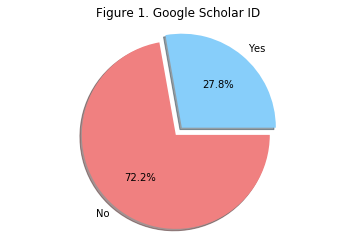

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Import CSV file 
df = pd.read_csv('salary_gscholar_Washington.csv')
      
### Plot number of scholars with google scholar ID (Yes or No)
def plotGscholarID(df):
    # Filter out NA
    n_total = len(df)
    n_NA = df['Total Citations'].isnull().sum()
    df.dropna(how='any', inplace=True)
    n = len(df)
    print "Number of scholars missing Google Scholar:", n_NA, "/", n_total
    print "Number of scholars with Google Scholar:", n, "/", n_total
    # Plot pie chart
    labels = 'Yes', 'No'
    sizes = [n, n_NA]
    colors = ['lightskyblue', 'lightcoral']
    explode = (0.1,0)
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
    plt.axis('equal')
    plt.title('Figure 1. Google Scholar ID')
    plt.show()
    return

plotGscholarID(df)


About 28% of the queried scholars have Google Scholar ID, and 72% don't have Google Scholar ID. 

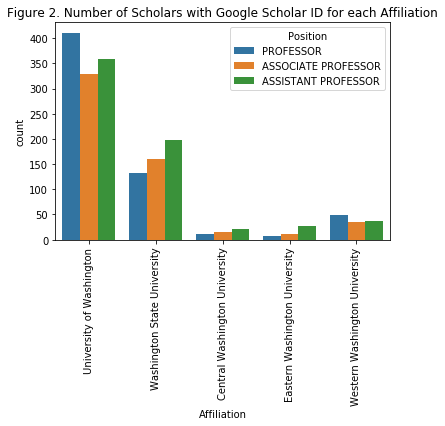

In [2]:
### Count number of scholars with google scholar ID for each affiliation and position
def countGscholarID_aff(df):
    # Filter out NA
    df.dropna(how='any', inplace=True)
    # Draw countplot
    sns.countplot(x="Affiliation", data=df, hue='Position')
    plt.title('Figure 2. Number of Scholars with Google Scholar ID for each Affiliation')
    plt.xticks(rotation=90)
    plt.show()
    return

countGscholarID_aff(df)

Majority of extracted publication record from Google Scholar was either from University of Washington or Washington State University

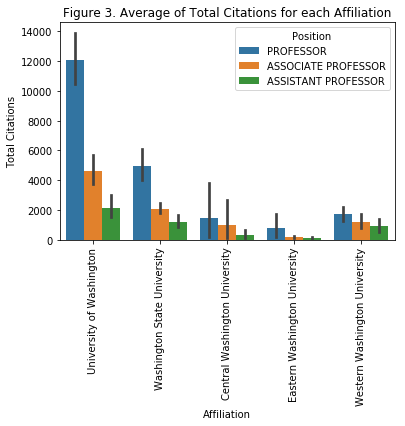

In [3]:
### Plot average number of total citations for each affiliation and position
def avgCitations(df):
    # Filter out NA
    df.dropna(how='any', inplace=True)
    # Plot bar graph
    sns.barplot(x="Affiliation", y="Total Citations", data=df, hue='Position')
    plt.title('Figure 3. Average of Total Citations for each Affiliation')
    plt.xticks(rotation=90)
    plt.show()
    return

avgCitations(df)

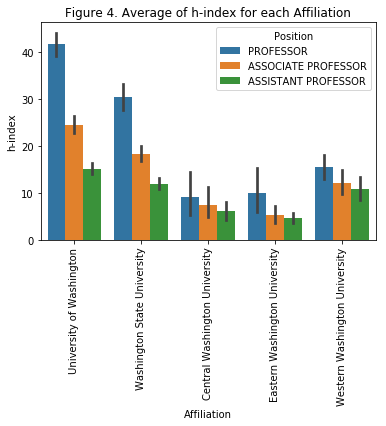

In [4]:
### Plot average number of h-index for each position
def avgHindex(df):
    # Filter out NA
    df.dropna(how='any', inplace=True)
    # Plot bar graph
    sns.barplot(x="Affiliation", y="h-index", data=df, hue='Position')
    plt.title('Figure 4. Average of h-index for each Affiliation')
    plt.xticks(rotation=90)
    plt.show()
    return

avgHindex(df)

On average, professors tend to have better publication record (i.e. higher total number of citations, and h-index) than associate professors, who have better publication record than assistant professors. This pattern is expected since full professors tend to have longer career experience than associate professors, and associate professors tend to have longer career experience than assistant professors; hence they had more time to accumulate higher number of citations, h-index or other metrics that describe one's publication record.

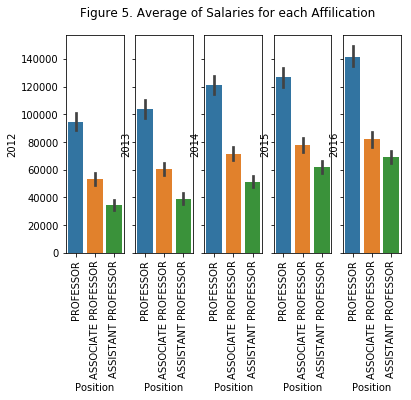

In [5]:
### Plot average salaries for each position 
def avgSalaries_Pos(df):
    # Filter out NA
    df.dropna(how='any', inplace=True)
    # Plot salaries
    f, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1,5, sharex=True, sharey=True)
    sns.barplot(x="Position", y="2012", data=df, ax=ax1)
    sns.barplot(x="Position", y="2013", data=df, ax=ax2)
    sns.barplot(x="Position", y="2014", data=df, ax=ax3)
    sns.barplot(x="Position", y="2015", data=df, ax=ax4)
    sns.barplot(x="Position", y="2016", data=df, ax=ax5)
    #sns.barplot(x="Position", y="Sum of 5 Year Salaries", data=df, ax=ax6)
    plt.setp(ax1.get_xticklabels(),rotation=90)
    plt.setp(ax2.get_xticklabels(),rotation=90)
    plt.setp(ax3.get_xticklabels(),rotation=90)
    plt.setp(ax4.get_xticklabels(),rotation=90)
    plt.setp(ax5.get_xticklabels(),rotation=90)
   
    plt.suptitle('Figure 5. Average of Salaries for each Affilication')
    plt.show()
    return

avgSalaries_Pos(df)

On average, professors had higher salaries than associate professors, who had higher salaries than assistant professors. 

2012 Salary, Number of Zeros 763 / 1804
2013 Salary, Number of Zeros 666 / 1804
2014 Salary, Number of Zeros 520 / 1804
2015 Salary, Number of Zeros 503 / 1804
2016 Salary, Number of Zeros 443 / 1804


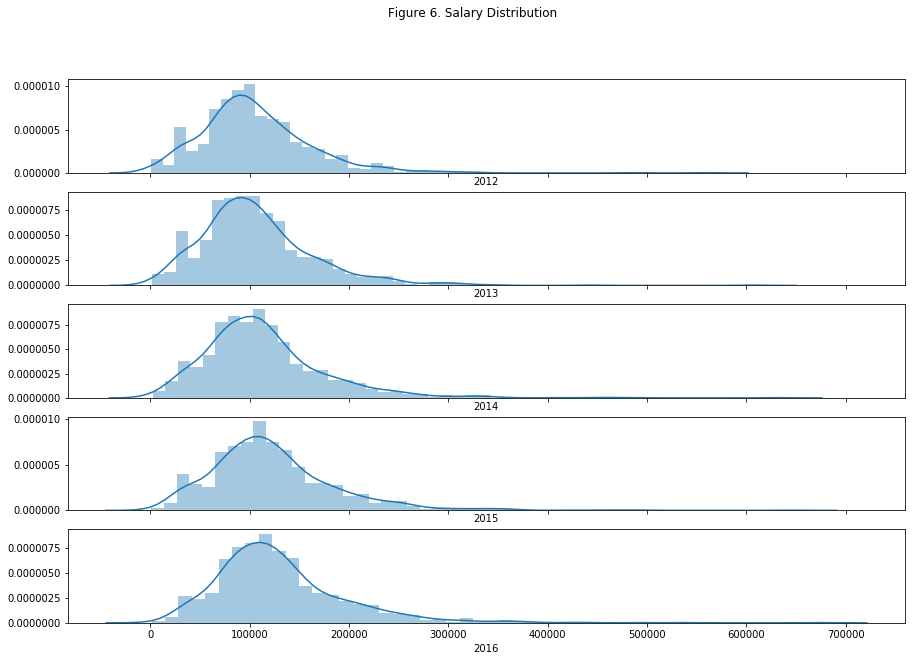

In [7]:
from removeZero import removeZero
### Plot Publication Record Distribution

### Import CSV file 
df = pd.read_csv('salary_gscholar_Washington.csv')
df.dropna(how='any', inplace=True)
df = df.reset_index()

df_2012, df_2013, df_2014, df_2015, df_2016 = removeZero(df)
   
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, sharex=True, figsize=(15,10))

sns.distplot(df_2012['2012'], ax=ax1)
sns.distplot(df_2013['2013'], ax=ax2)
sns.distplot(df_2014['2014'], ax=ax3)
sns.distplot(df_2015['2015'], ax=ax4)
sns.distplot(df_2016['2016'], ax=ax5)
##plt.setp(ax4.get_xticklabels(), rotation=90)
##plt.setp(ax5.get_xticklabels(), rotation=90)
##plt.setp(ax6.get_xticklabels(), rotation=90)

##plt.setp(ax4.get_xticklabels(), rotation=90)
##plt.setp(ax5.get_xticklabels(), rotation=90)
##plt.setp(ax6.get_xticklabels(), rotation=90)

plt.suptitle('Figure 6. Salary Distribution')
plt.show()

Most salaries are between ~80000 and 120000. 

2012 Salary, Number of Zeros 763 / 1804
2013 Salary, Number of Zeros 666 / 1804
2014 Salary, Number of Zeros 520 / 1804
2015 Salary, Number of Zeros 503 / 1804
2016 Salary, Number of Zeros 443 / 1804


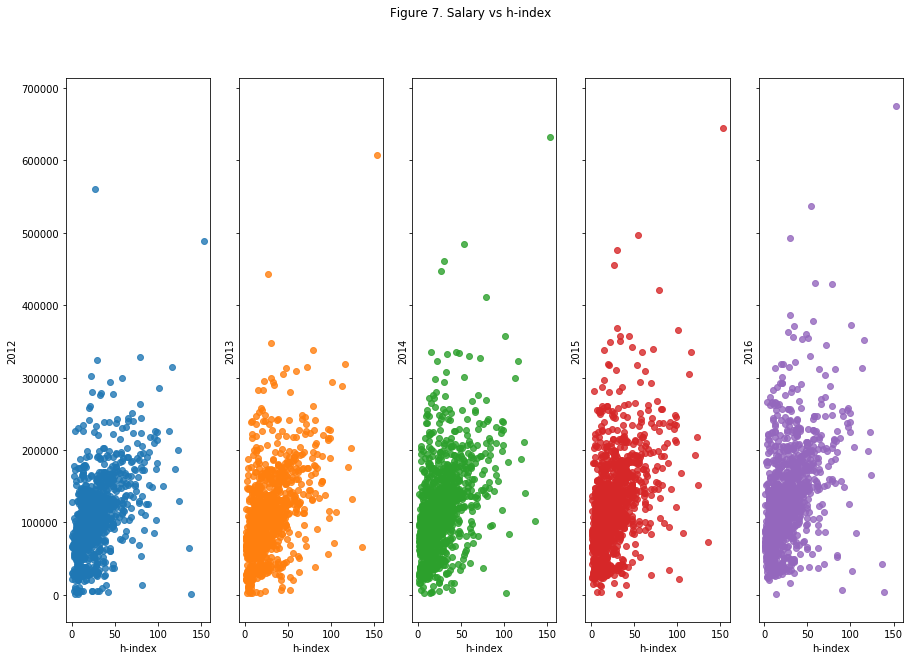

In [8]:
### Remove zero salaries for each year
def removeZero(df):
    #Count number of zeros in each year's salary
    print "2012 Salary, Number of Zeros", len(df[df['2012'] == 0]), '/', len(df)
    print "2013 Salary, Number of Zeros", len(df[df['2013'] == 0]), '/', len(df)
    print "2014 Salary, Number of Zeros", len(df[df['2014'] == 0]), '/', len(df)
    print "2015 Salary, Number of Zeros", len(df[df['2015'] == 0]), '/', len(df)
    print "2016 Salary, Number of Zeros", len(df[df['2016'] == 0]), '/', len(df)

    df_2012 = df.loc[(df['2012']!=0)].reset_index()
    df_2013 = df.loc[(df['2013']!=0)].reset_index()
    df_2014 = df.loc[(df['2014']!=0)].reset_index()
    df_2015 = df.loc[(df['2015']!=0)].reset_index()
    df_2016 = df.loc[(df['2016']!=0)].reset_index()
      
    return df_2012, df_2013, df_2014, df_2015, df_2016


df_2012, df_2013, df_2014, df_2015, df_2016 = removeZero(df)


####### Plot Salaries vs. h-index Citations
#f=plt.figure(figsize=(5, 5), dpi=50, facecolor='w', edgecolor='k')
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, sharey=True, figsize=(15,10))
sns.regplot(x="h-index", y="2012", data=df_2012, fit_reg=False, ax=ax1)
sns.regplot(x="h-index", y="2013", data=df_2013, fit_reg=False, ax=ax2)
sns.regplot(x="h-index", y="2014", data=df_2014, fit_reg=False, ax=ax3)
sns.regplot(x="h-index", y="2015", data=df_2015, fit_reg=False, ax=ax4)
sns.regplot(x="h-index", y="2016", data=df_2016, fit_reg=False, ax=ax5)

#import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (20,20)
plt.suptitle('Figure 7. Salary vs h-index')
plt.show(f)

As shown above, there seems to be a positive correlation between h-index and each year's salary (2012-2016). 

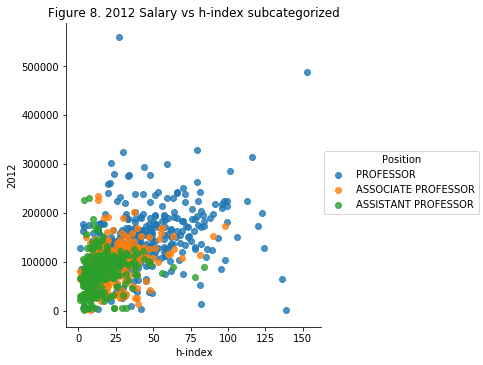

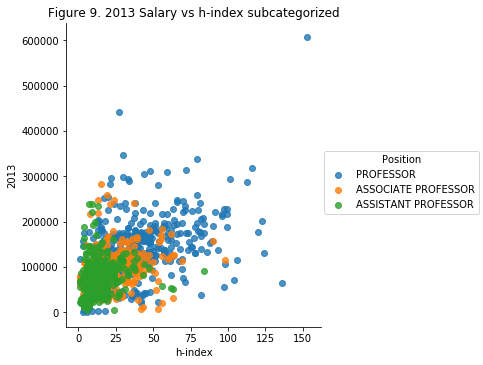

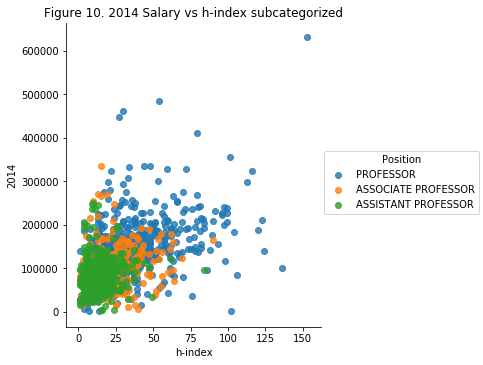

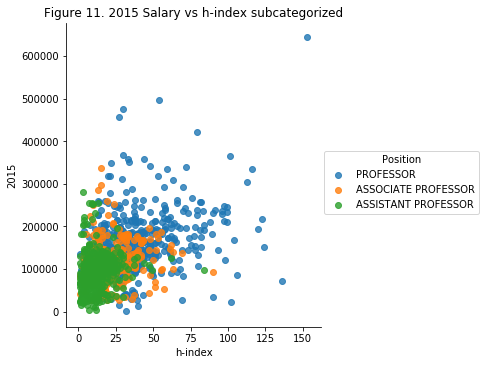

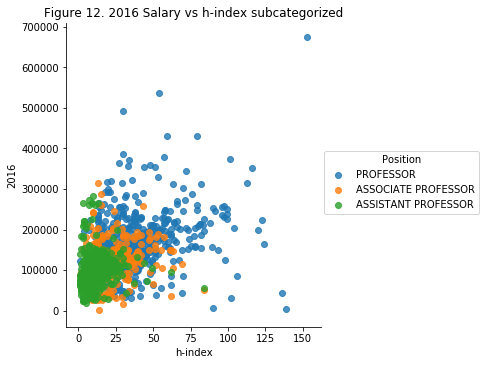

In [12]:
### Plot Salary vs h-index per position and affiliation 


sns.lmplot(x="h-index", y="2012", data=df_2012, fit_reg=False, hue='Position')
plt.title('Figure 8. 2012 Salary vs h-index subcategorized')
sns.lmplot(x="h-index", y="2013", data=df_2013, fit_reg=False, hue='Position')
plt.title('Figure 9. 2013 Salary vs h-index subcategorized')
sns.lmplot(x="h-index", y="2014", data=df_2014, fit_reg=False, hue='Position')
plt.title('Figure 10. 2014 Salary vs h-index subcategorized')
sns.lmplot(x="h-index", y="2015", data=df_2015, fit_reg=False, hue='Position')
plt.title('Figure 11. 2015 Salary vs h-index subcategorized')
sns.lmplot(x="h-index", y="2016", data=df_2016, fit_reg=False, hue='Position')
plt.title('Figure 12. 2016 Salary vs h-index subcategorized')

plt.show()

Seems like Assistant Professor cluster is centered closest to the bottom left, Associate Professors cluster is shown more to the top right, and Full Prof cluster is the one that is the most to the top right. 

2012 Salary, Number of Zeros 763 / 1804
2013 Salary, Number of Zeros 666 / 1804
2014 Salary, Number of Zeros 520 / 1804
2015 Salary, Number of Zeros 503 / 1804
2016 Salary, Number of Zeros 443 / 1804


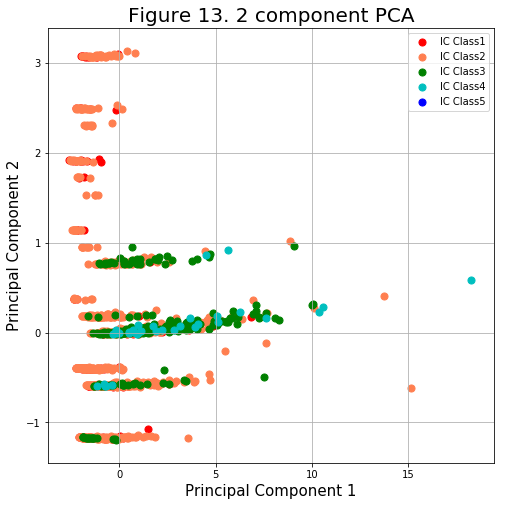

In [13]:
### Principal Component Analysis

### Import CSV file 
df = pd.read_csv('salary_gscholar_Washington.csv')

### Filter out rows with empty Google Scholar
df.dropna(how='any', inplace=True)
df = df.reset_index()

### Convert Position to Ordinals
def convertPos(df):
    df.loc[df['Position'] == 'PROFESSOR', 'Position'] = 1
    df.loc[df['Position'] == 'ASSOCIATE PROFESSOR', 'Position'] = 2
    df.loc[df['Position'] == 'ASSISTANT PROFESSOR', 'Position'] = 3
    return df

df = convertPos(df)

### Convert Affiliation to Ordinals
def convertAff(df):

    df.loc[df['Affiliation'] == 'University of Washington', 'Affiliation'] = 1
    df.loc[df['Affiliation'] == 'Washington State University', 'Affiliation'] = 2
    df.loc[df['Affiliation'] == 'Central Washington University', 'Affiliation'] = 3
    df.loc[df['Affiliation'] == 'Eastern Washington University', 'Affiliation'] = 4
    df.loc[df['Affiliation'] == 'Western Washington University', 'Affiliation'] = 5

    return df

df = convertAff(df)

##### Filter out zeroes
df_2012, df_2013, df_2014, df_2015, df_2016 = removeZero(df)

### Bin salaries into 5 categories (IC Class1 = $0-50000, IC Class2 = $50000-150000, IC Class3 = $150000-250000, IC Class4 = greater than $250000
def binSalary(df):
    df.loc[df['2012'] >= 250000, '2012'] = 'IC Class4'
    df.loc[df['2012'] < 50000, '2012'] = 'IC Class1'
    df.loc[df['2012'] < 150000, '2012'] = 'IC Class2'
    df.loc[df['2012'] < 250000, '2012'] = 'IC Class3'

    df.loc[df['2013'] >= 250000, '2013'] = 'IC Class4'
    df.loc[df['2013'] < 50000, '2013'] = 'IC Class1'
    df.loc[df['2013'] < 150000, '2013'] = 'IC Class2'
    df.loc[df['2013'] < 250000, '2013'] = 'IC Class3'

    df.loc[df['2014'] >= 250000, '2014'] = 'IC Class4'
    df.loc[df['2014'] < 50000, '2014'] = 'IC Class1'
    df.loc[df['2014'] < 150000, '2014'] = 'IC Class2'
    df.loc[df['2014'] < 250000, '2014'] = 'IC Class3'

    df.loc[df['2015'] >= 250000, '2015'] = 'IC Class4'
    df.loc[df['2015'] < 50000, '2015'] = 'IC Class1'
    df.loc[df['2015'] < 150000, '2015'] = 'IC Class2'
    df.loc[df['2015'] < 250000, '2015'] = 'IC Class3'

    df.loc[df['2016'] >= 250000, '2016'] = 'IC Class4'
    df.loc[df['2016'] < 50000, '2016'] = 'IC Class1'
    df.loc[df['2016'] < 150000, '2016'] = 'IC Class2'
    df.loc[df['2016'] < 250000, '2016'] = 'IC Class3'
    
    return df

df_2014 = binSalary(df_2014)

## Standardize data (feature scaling)
from sklearn.preprocessing import StandardScaler
features = ['h-index', '5 year h-index', '5 year i10-index', 'i10-index', 'Total Citations', 'Affiliation', 'Position']
x = df_2014.loc[:, features].values
##y = df_2014.loc[:,['2014']].values
x = StandardScaler().fit_transform(x)

### PCA projection to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_2014[['2014']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
##ax = Axes3D(fig)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
##ax.set_zlabel('Principal Componen 3', fontsize = 15)
ax.set_title('Figure 13. 2 component PCA', fontsize = 20)
targets = ['IC Class1', 'IC Class2', 'IC Class3', 'IC Class4', 'IC Class5']
colors = ['r', 'coral','g', 'c','b' ]
sz = 10
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['2014'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()


This PCA is not done correctly because I have added two categorical features into PCA (Position and Affiliation). I could probably try categorizing/binning all my features and trying Multiple Correspondance Analysis (MCA) instead. Nonetheless even from this analysis, we can visualize two clusters. One cluster that is near the top left (IC Class IC Class2), and another cluster that is more to the bottom right (IC Class3, IC Class4, IC Class5). 


For the future work, I will be scraping extra data from google scholar to extract research interests and yearly number of citations. From this data I could do some feature scaling on publication record based on the research field. The idea is that some academic fields value publication of research papers higher than the others.

Below is the code that I will be using to extract this information from Google Scholar.

In [ ]:
### Extra data scraping from Google Scholar

import scholarly
import pandas as pd
import time
from time import sleep
from random import randint

### Import CSV file containing salaries and gscholar information of UW professsors

df = pd.read_csv('salary_gscholar_Washington.csv')

### Filter out NA
df.dropna(how='any', inplace=True)
df = df.reset_index()

### Extra data mining from google scholar. Go through all names in df, extract yearly citations and research interests
start_time = time.time()
n = len(df)
interests = []
cites_per_year = []
for index in range(0,n):
    sleep(randint(1,10))
    print "Searching Number:", index+1, '/', n
    name = df.Name[index]
    position = df.Position[index]
    aff = df.Affiliation[index]
    print name, "(", position, ")", "in", aff
    search_query = scholarly.search_author(name + ',' + aff)
    author = next(search_query, None)
    if author is None:
        interests.append( 'NA' )
        cites_per_year.append( 'NA' )
        continue
    else:
        author = author.fill()
        try:
            interests.append( author.interests )       
        except AttributeError:
            interests.append( 'NA' )
        try:
            cites_per_year.append( author.cites_per_year )
        except AttributeError:
            cites_per_year.append( 'NA' )
        
df['interests'] = interests
df['cites_per_year'] = cites_per_year
df.to_csv('salary_gscholar_Washington_extraMining.csv')
elapsed_time = time.time() - start_time
print time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
